In [97]:
import gensim
import pandas as pd
import nltk
from nltk.corpus import stopwords
import re
import numpy as np
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import TfidfModel
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models import LsiModel
import spacy
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
from pprint import pprint
import dill
import os
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

nltk.download("stopwords")
%load_ext lab_black

import warnings

warnings.filterwarnings("ignore")

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dlwss\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Question 1
### (1) Figure out a good number of topics. Show the reason why you choose this number.

I decided to choose 2 Topics based on the best Coherence Score I obtained by conducting LDA on a BOW matrix of the dictionary of words from the review body found in the given dataset. 

After trying out LDA on a BOW matrix, LSA on a BOW matrix, LDA on as TFIDF matrix and LSA on a BOW matrix, the highest coherence score obtained was 0.6554 for 2 topics with LDA on a BOW matrix.

I used the coherence score to measure the best number of topics to use as it represents that multiple words belonging to a given topic co occur frequently in the given corpus. Thus a higher coherence score would represent better topic representation.

Workings and Coherence Score graphs can be found below.

In [7]:
df = pd.read_csv("data_assignment3_students.csv")

In [8]:
stop_words = stopwords.words("english")
stop_words.extend(["from", "subject", "re", "edu", "use", "non", "hold", "br"])
stop_words = stop_words + list(STOPWORDS)
nlp = spacy.load("en", disable=["parser", "ner"])

In [9]:
def remove_stopwords(texts):
    return [
        [word for word in simple_preprocess(str(doc)) if word not in stop_words]
        for doc in texts
    ]


def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]


def lemmatization(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append(
            [token.lemma_ for token in doc if token.pos_ in allowed_postags]
        )
    return texts_out


def sent_to_words(sentences):
    for sentence in sentences:
        yield (gensim.utils.simple_preprocess(str(sentence), deacc=True))

In [24]:
def compute_coherence_values(corpus, texts, limit, start=2, step=3, dictionary=id2word):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            random_state=100,
            update_every=1,
            chunksize=100,
            passes=20,
            alpha="auto",
            per_word_topics=True,
        )
        model_list.append(model)
        coherencemodel = CoherenceModel(
            model=model, texts=texts, dictionary=dictionary, coherence="c_v"
        )
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [20]:
data = df.review_body.values.tolist()
data_words = list(sent_to_words(data))
data_words_nostops = remove_stopwords(data_words)
data_lemmatized = lemmatization(
    data_words_nostops, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]
)

In [21]:
id2word = corpora.Dictionary(data_lemmatized)

texts = data_lemmatized

corpus = [id2word.doc2bow(text) for text in texts]

In [8]:
model = TfidfModel(corpus)
tfidf_corpus = model[corpus]

## BoW LDA

In [19]:
model_list_bow, coherence_values_bow = compute_coherence_values(
    dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=50, step=6
)

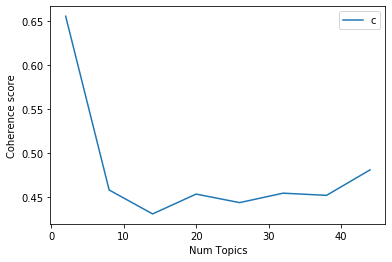

In [20]:
limit_bow = 50
start_bow = 2
step_bow = 6
x_bow = range(start_bow, limit_bow, step_bow)
plt.plot(x_bow, coherence_values_bow)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc="best")
plt.show()

In [21]:
# Print the coherence scores
for m, cv in zip(x_bow, coherence_values_bow):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.6554
Num Topics = 8  has Coherence Value of 0.4577
Num Topics = 14  has Coherence Value of 0.4305
Num Topics = 20  has Coherence Value of 0.4531
Num Topics = 26  has Coherence Value of 0.4434
Num Topics = 32  has Coherence Value of 0.4541
Num Topics = 38  has Coherence Value of 0.4516
Num Topics = 44  has Coherence Value of 0.4806


In [22]:
optimal_model_bow = model_list_bow[0]
top_topics_bow = optimal_model_bow.top_topics(texts=data_lemmatized, coherence="c_v")
pprint(top_topics_bow)

[([(0.10813569, 'card'),
   (0.012656959, 'humanity'),
   (0.011567607, 'answer'),
   (0.010209584, 'box'),
   (0.007977148, 'player'),
   (0.0071689426, 'know'),
   (0.0070111696, 'black'),
   (0.0068611074, 'read'),
   (0.006447003, 'try'),
   (0.0061321366, 'word'),
   (0.006072055, 'joke'),
   (0.0058408403, 'review'),
   (0.005627816, 'person'),
   (0.0054410324, 'deck'),
   (0.005433269, 'question'),
   (0.005363216, 'feel'),
   (0.0052533285, 'white'),
   (0.0051686075, 'set'),
   (0.0050134715, 'think'),
   (0.0048181494, 'rule')],
  0.8413779698377828),
 ([(0.115650274, 'game'),
   (0.055145077, 'play'),
   (0.040038884, 'fun'),
   (0.027400777, 'friend'),
   (0.026719207, 'great'),
   (0.022282222, 'love'),
   (0.018627847, 'good'),
   (0.01729912, 'time'),
   (0.0172548, 'people'),
   (0.017055871, 'laugh'),
   (0.01583155, 'apple'),
   (0.01358452, 'buy'),
   (0.012926953, 'adult'),
   (0.012308625, 'party'),
   (0.011027284, 'expansion'),
   (0.0105476305, 'hilarious'),
  

## TFIDF LDA

In [23]:
model_list_tfidf, coherence_values_tfidf = compute_coherence_values(
    dictionary=id2word,
    corpus=tfidf_corpus,
    texts=data_lemmatized,
    start=2,
    limit=50,
    step=6,
)

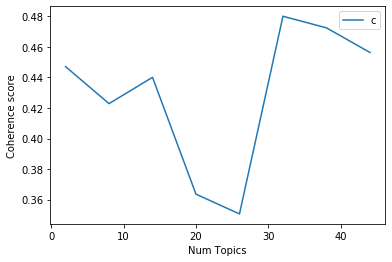

In [24]:
tfidf_limit = 50
tfidf_start = 2
tfidf_step = 6
tfidf_x = range(tfidf_start, tfidf_limit, tfidf_step)
plt.plot(tfidf_x, coherence_values_tfidf)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc="best")
plt.show()

In [25]:
# Print the coherence scores
for m, cv in zip(tfidf_x, coherence_values_tfidf):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4472
Num Topics = 8  has Coherence Value of 0.4229
Num Topics = 14  has Coherence Value of 0.4401
Num Topics = 20  has Coherence Value of 0.3635
Num Topics = 26  has Coherence Value of 0.3506
Num Topics = 32  has Coherence Value of 0.4802
Num Topics = 38  has Coherence Value of 0.4726
Num Topics = 44  has Coherence Value of 0.4564


## BOW LSI

In [27]:
def compute_coherence_values_lsi(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LsiModel(
            corpus=corpus, id2word=id2word, num_topics=num_topics, chunksize=100
        )
        model_list.append(model)
        coherencemodel = CoherenceModel(
            model=model, texts=texts, dictionary=dictionary, coherence="c_v"
        )
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [28]:
model_list_bow_lsi, coherence_values_bow_lsi = compute_coherence_values_lsi(
    dictionary=id2word,
    corpus=tfidf_corpus,
    texts=data_lemmatized,
    start=2,
    limit=50,
    step=6,
)

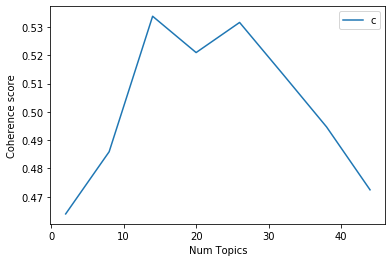

In [29]:
bow_lsi_limit = 50
bow_lsi_start = 2
bow_lsi_step = 6
bow_lsi_x = range(bow_lsi_start, bow_lsi_limit, bow_lsi_step)
plt.plot(bow_lsi_x, coherence_values_bow_lsi)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc="best")
plt.show()

In [30]:
# Print the coherence scores
for m, cv in zip(bow_lsi_x, coherence_values_bow_lsi):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4639
Num Topics = 8  has Coherence Value of 0.4859
Num Topics = 14  has Coherence Value of 0.5338
Num Topics = 20  has Coherence Value of 0.5209
Num Topics = 26  has Coherence Value of 0.5316
Num Topics = 32  has Coherence Value of 0.5132
Num Topics = 38  has Coherence Value of 0.4947
Num Topics = 44  has Coherence Value of 0.4724


## TFIDF LSI

In [32]:
model_list_tfidf_lsi, coherence_values_tfidf_lsi = compute_coherence_values_lsi(
    dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=50, step=6
)

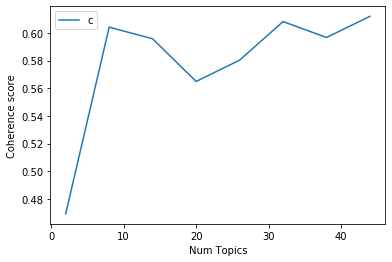

In [33]:
tfidf_lsi_limit = 50
tfidf_lsi_start = 2
tfidf_lsi_step = 6
tfidf_lsi_x = range(tfidf_lsi_start, tfidf_lsi_limit, tfidf_lsi_step)
plt.plot(tfidf_lsi_x, coherence_values_tfidf_lsi)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc="best")
plt.show()

In [34]:
# Print the coherence scores
for m, cv in zip(tfidf_lsi_x, coherence_values_tfidf_lsi):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4692
Num Topics = 8  has Coherence Value of 0.6042
Num Topics = 14  has Coherence Value of 0.5957
Num Topics = 20  has Coherence Value of 0.5649
Num Topics = 26  has Coherence Value of 0.5803
Num Topics = 32  has Coherence Value of 0.6082
Num Topics = 38  has Coherence Value of 0.5967
Num Topics = 44  has Coherence Value of 0.612


# Question 2
### (2) Print out the resulting topics, each topic as a list of 20 words.

In [98]:
lst = []
for j in range(0, 2):
    top = pd.Series([top_topics_bow[j][0][i][1] for i in range(0, 20)])
    lst.append(top)

In [42]:
words = pd.DataFrame(lst).T
words.columns = [("Topic " + str(x + 1)) for x in words.columns]
words.index = [("Word " + str(x + 1)) for x in words.index]
words

,Topic 1,Topic 2
Word 1,card,game
Word 2,humanity,play
Word 3,answer,fun
Word 4,box,friend
Word 5,player,great
Word 6,know,love
Word 7,black,good
Word 8,read,time
Word 9,try,people
Word 10,word,laugh


# Question 3
### (3) Summarize the change of topics that consumers talk about this product over time.

After doing LDA on the entire corpus and retrieving two topics, I realised that Topic 1 was referring more towards the "Card against Humanity" product specifically while Topic 2 refers more towards "Entertainment" in general.

I split the corpus into 5 years, 2011, 2012, 2013, 2014 and 2015.

The 2 topics have stayed similar in each of the 5 years after looking at the top 20 words printed for each topic for each of the 5 years.

However, in 2014 and 2015 I noted words in the "Cards against Humanity" topic such as "Horrible", "Offensive", "Horrify" and "Stupid" which I can infer were negative reviews related to the product. On the other hand, in 2011 and 2012 I noted words in the same topic such as "Recommend", "Good", "Love" and "Fun" which I can infer were positive reviews related to the product.

Thus, I can infer that there was a general change of perception towards "Cards against Humanity" from more positive reviews in 2011 and 2012 to more negative reviews in 2014 and 2015.

In each of the 5 years the Coherence score of Topic 1 was higher than Topic 2. However the gap enlarged dramatically in 2013. I can infer that the "Cards against Humanity" product was discussed more frequently than "Entertainment" but relatively much more in 2013.

The Coherence score for both topics generally increased each year with the exception being Topic 1 decreasing from 2013 to 2014 after a large spike. Meaning the two topics were discussed more and more each year relative to other topics. 

Workings, Top 20 words for each topic for each year, a table of Coherences scores and a graph of Coherence Scores can be found below.

In [11]:
df.review_date = pd.to_datetime(df.review_date)
df.year = df.review_date.dt.year

In [12]:
years = list(df.year.unique())
dflist = ["df" + str(x) for x in years]
yearint = [int(i) for i in years]
dfdict = {}
for (x, z) in zip(dflist, yearint):
    dfdict[x] = pd.DataFrame()
    dfdict[x] = df[df.year == z]

In [13]:
def data_process(df):
    data = df.review_body.values.tolist()
    data_words = list(sent_to_words(data))
    data_words_nostops = remove_stopwords(data_words)
    data_lemmatized = lemmatization(
        data_words_nostops, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]
    )
    return data_lemmatized


def data_id2word(lemmadict):
    id2word = corpora.Dictionary(lemmadict)
    return id2word


def data_corpus(lemmadict, id2worddict):
    corpus = [id2worddict.doc2bow(text) for text in lemmadict]
    return corpus

In [14]:
corpusdict = {}
id2worddict = {}
lemmadict = {}
for key in dfdict:
    lemmadict[key] = data_process(dfdict[key])
    id2worddict[key] = data_id2word(lemmadict[key])
    corpusdict[key] = data_corpus(lemmadict[key], id2worddict[key])

In [25]:
modeldict = {}
coherencedict = {}

for key in dfdict:
    modeldict[key], coherencedict[key] = compute_coherence_values(
        dictionary=id2worddict[key],
        corpus=corpusdict[key],
        texts=lemmadict[key],
        start=2,
        limit=50,
        step=6,
    )

In [62]:
# Print the coherence scores
score = pd.DataFrame(columns=["Topic_1", "Topic_2"], index=list(modeldict.keys()))
for key in modeldict:
    print(key)
    optimal_model_bow = modeldict[key][0]
    top_topics_bow = optimal_model_bow.top_topics(texts=lemmadict[key], coherence="c_v")
    pprint(top_topics_bow)
    for j in range(0, 2):
        score.loc[key][j] = top_topics_bow[j][1]
    print("\n\n\n")

df2014
[([(0.091058575, 'card'),
   (0.044152655, 'apple'),
   (0.0138595225, 'say'),
   (0.010853894, 'answer'),
   (0.010830854, 'win'),
   (0.009949914, 'think'),
   (0.009467353, 'player'),
   (0.008973364, 'person'),
   (0.008808316, 'type'),
   (0.00805101, 'humanity'),
   (0.007875266, 'box'),
   (0.007836415, 'simply'),
   (0.007629881, 'version'),
   (0.0076219314, 'stupid'),
   (0.0075949198, 'site'),
   (0.0074601485, 'toss'),
   (0.007330065, 'horrify'),
   (0.0071658376, 'read'),
   (0.0070010764, 'black'),
   (0.006833449, 'actually')],
  0.4962588885179689),
 ([(0.110466965, 'game'),
   (0.058150165, 'play'),
   (0.040296514, 'fun'),
   (0.031074127, 'friend'),
   (0.021009212, 'love'),
   (0.019991126, 'people'),
   (0.019642342, 'great'),
   (0.01672898, 'laugh'),
   (0.01642822, 'good'),
   (0.015038522, 'time'),
   (0.014010193, 'adult'),
   (0.013484832, 'hilarious'),
   (0.012167344, 'buy'),
   (0.01170538, 'group'),
   (0.010518862, 'humor'),
   (0.010211912, 'par

In [104]:
score.index = ["2015", "2013", "2014", "2011", "2012"]
score = score.sort_index()

In [105]:
score

,Topic_1,Topic_2
2011,0.286944,0.218872
2012,0.47789,0.36132
2013,0.661891,0.352706
2014,0.496259,0.417313
2015,0.640609,0.465311


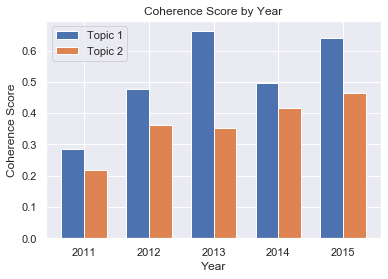

In [109]:
fig, ax = plt.subplots()
x = np.arange(len(score))
width = 0.35


ax.bar(x - width / 2, score["Topic_1"], width, edgecolor="white", label="Topic 1")
ax.bar(x + width / 2, score["Topic_2"], width, edgecolor="white", label="Topic 2")

ax.set_xticklabels(["", "2011", "2012", "2013", "2014", "2015"])
ax.legend()
ax.set_ylabel("Coherence Score")
ax.set_xlabel("Year")
ax.set_title("Coherence Score by Year")

plt.show()